<a href="https://colab.research.google.com/github/damoon843/al-gore-ithms/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install packages
!pip install -U tmtoolkit
!pip install matplotlib==3.1.1
!pip install svgpath2mpl 

     |████████████████████████████████| 7.1 MB 11.1 MB/s 
     |████████████████████████████████| 11.5 MB 52.1 MB/s 
     |████████████████████████████████| 10.4 MB 42.7 MB/s 
     |████████████████████████████████| 25.9 MB 961 bytes/s 
     |████████████████████████████████| 96 kB 3.4 MB/s 
     |████████████████████████████████| 1.0 MB 34.6 MB/s 
  Created wheel for globre: filename=globre-0.1.5-py3-none-any.whl size=19546 sha256=08dce84cafb96b1657ddcb163d577f6adc71fb472164eb4eab3ddd63ce5a4e32
  Stored in directory: /root/.cache/pip/wheels/40/95/37/5303ce04fce53b6e64ed74a3f0a0e9ea11c348cac0c5c42a76
Successfully built globre
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4

     |████████████████████████████████| 13.1 MB 6.6 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tmtoolkit 0.10.0 requires matplotlib<3.4,>=3.3.0, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
from collections import defaultdict
import json
import pandas as pd 
import numpy as np 
import requests 
import datetime
from bs4 import BeautifulSoup
import statsmodels.api as sm
from statsmodels.tools import eval_measures
import copy

# Text processing imports
import spacy
parser = spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
from svgpath2mpl import parse_path

# Statistical test imports
import scipy
import statsmodels
from scipy.stats import friedmanchisquare
from statsmodels.graphics.gofplots import qqplot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.7). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


# DATA DELIVERABLE (CHECKPOINT 1)

## CONSTRUCT THE DATASET

In [3]:

# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

# Dataset from: https://www.whitehouse.gov/omb/historical-tables/
# NOTE: make sure the shared projet folder follows this path
with open('/content/drive/My Drive/CS1951A Final Project/hist05z2_fy22.csv', 'r', encoding='utf-8') as data:
  budget_df = pd.read_csv(data, header=2, index_col="Department or other unit")


Mounted at /content/drive


In [4]:
budget_df.head(4)

,1976,TQ,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021 estimate,2022 estimate,2023 estimate,2024 estimate,2025 estimate,2026 estimate
Department or other unit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Legislative Branch,936,226,"1,057","1,087","1,131","1,318","1,251","1,414","1,687","1,768","1,703","1,720","1,873","2,123","2,250","2,248","2,493","2,632","2,621","2,612","2,682","2,454","2,541","2,627","2,943","2,800","3,149","3,613","3,830","3,937","4,036","4,219","4,286","4,447","4,977","4,893","4,737","4,542","4,258","4,462","4,506","4,570","4,686","4,981","5,061","5,376","5,628","6,147","6,288","6,421","6,544","6,685"
Judicial Branch,346,87,431,459,521,609,656,733,823,904,"1,055","1,045","1,273","1,344","1,481","1,752","2,118","2,445","2,613","2,832","2,998","3,174","3,386","3,543","3,807","4,067","4,459","4,970","5,168","5,440","5,726","5,993","6,180","6,518","6,787","7,214","7,205","7,240","6,926","7,284","7,404","7,596","7,760","7,908","8,134","8,413","8,610","9,161","9,341","9,550","9,762","9,960"
Department of Agriculture,"20,690","4,233","21,841","26,659","37,250","39,559","47,410","57,400","69,831","46,734","61,823","59,154","52,421","55,134","55,627","55,214","59,957","66,170","67,730","65,458","58,437","58,592","60,727","58,134","67,560","75,162","73,082","71,209","78,750","93,037","95,023","97,339","91,821","92,950","127,826","130,983","140,677","151,789","154,924","157,510","142,471","168,801","136,547","142,537","166,709","235,204","261,119","249,259","170,951","173,031","173,829","174,009"
Department of Commerce,"1,732",357,"7,814","1,892","2,086","2,610","2,072","1,834","1,923","2,015","2,309","1,980","2,155","2,449","2,807","3,683","2,648","3,022","3,159","3,811","4,025","3,612","3,758","4,100","5,431","8,733","5,167","5,545","5,800","5,877","6,476","6,638","7,766","9,585","25,713","13,679","5,704","7,978","7,959","10,113","13,817","10,351","9,486","18,269","12,520","17,388","14,308","80,257","25,133","37,396","25,717","20,178"


In [5]:
# Webscrape State of The Union Addresses
# Dataset from: https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union

speech_table_url = "https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union"
def get_yearly_speeches():
    response = requests.get(speech_table_url, auth=('user', 'pass'))
    # print("response: ", response, type(response))
    # print("response.text: ", response.text, type(response.text))
    html_dump = BeautifulSoup(response.text, 'html.parser')

    # list of all the things with the lable "table"
    html_tables = html_dump.find('table')
    cols = html_tables.find("tbody")
    all_speeches_url = []
    speeches = cols.find_all("tr")
    # print(stocks)
    for i in speeches:
        entry = i.find_all("td")
        for j in entry:
          potential_link = j.a
          # print(potential_link)
          if type(j.text.strip()) is str and len(j.text.strip()) > 9:
            president = j.text.strip().lower()
            # print("name = ",j.text.strip().lower())
          elif potential_link is not None:
            year = potential_link.text
            url = potential_link['href']
            # print(potential_link.text, potential_link['href'])
            all_speeches_url.append({"president": president, "year":year, "url": url})
    return all_speeches_url
all_speeches_url = get_yearly_speeches()
print(all_speeches_url)

[{'president': '2021-present', 'year': '2021', 'url': 'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-3'}, {'president': 'donald j. trump', 'year': '2017', 'url': 'https://www.presidency.ucsb.edu/ws/index.php?pid=123408'}, {'president': 'donald j. trump', 'year': '2018', 'url': 'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-25'}, {'president': 'donald j. trump', 'year': '2019', 'url': 'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-26'}, {'president': 'donald j. trump', 'year': '2020', 'url': 'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-27'}, {'president': 'barack obama', 'year': '2013', 'url': 'https://www.presidency.ucsb.edu/ws/index.php?pid=102826'}, {'president': 'barack obama', 'year': '2014', 'url': 'https://www.presidency.ucsb.edu/ws/index.php?pid=104596'}, {'president':

In [6]:
for speech in all_speeches_url:
  # print(speech['president'])
  if(speech['president'] == 'gerald r. ford'):
    break
  response = requests.get(speech['url'])
  html_dump = BeautifulSoup(response.text, 'html.parser')
  # cols = html_tables.find("tbody")
  stocks = html_dump.find_all("section")
  full_text_together = ""
  for i in stocks:
    full_text_broken = i.find_all("p")
    # print("text", full_text_broken)
    for j in full_text_broken:
      # print("text", full_text)
      full_text_together += j.text + " "
      speech['speech'] = (full_text_together)
# print(all_speeches_url)

In [7]:
# Convert to pandas DF
speeches_df = pd.DataFrame(all_speeches_url)
speeches_df['president'][0] = 'joe biden'
speeches_df.head(48)

,president,year,url,speech
0,joe biden,2021,https://www.presidency.ucsb.edu/documents/addr...,About Search The President. Thank you. Thank ...
1,donald j. trump,2017,https://www.presidency.ucsb.edu/ws/index.php?p...,About Search Thank you very much. Mr. Speaker...
2,donald j. trump,2018,https://www.presidency.ucsb.edu/documents/addr...,"About Search The President. Mr. Speaker, Mr. ..."
3,donald j. trump,2019,https://www.presidency.ucsb.edu/documents/addr...,"About Search The President. Madam Speaker, Mr..."
4,donald j. trump,2020,https://www.presidency.ucsb.edu/documents/addr...,About Search The President. Thank you very mu...
5,barack obama,2013,https://www.presidency.ucsb.edu/ws/index.php?p...,"About Search Please, everybody, have a seat. ..."
6,barack obama,2014,https://www.presidency.ucsb.edu/ws/index.php?p...,"About Search The President. Mr. Speaker, Mr. ..."
7,barack obama,2015,https://www.presidency.ucsb.edu/ws/index.php?p...,"About Search The President. Mr. Speaker, Mr. ..."
8,barack obama,2016,https://www.presidency.ucsb.edu/ws/index.php?p...,"About Search Thank you. Mr. Speaker, Mr. Vice..."
9,barack obama,2009,https://www.presidency.ucsb.edu/ws/index.php?p...,"About Search Madam Speaker, Mr. Vice Presiden..."


Load in health dictionary dataset

In [8]:
with open('/content/drive/My Drive/CS1951A Final Project/health_dictionary.txt', 'r', encoding='utf-8') as data:
  items =  data.readlines()
  health_dic = [x.strip().lower() for x in items] 
print(health_dic)

health_dic.append(["insurance", "healthcare"])
print(len(health_dic))

['disease', 'disability', 'diabetes', 'disabilities', 'doctor', 'mental', 'epidemiology', 'epidemiologic', 'health', 'health care', 'health care provider', 'health care setting', 'health disparities', 'immune system', 'immunization', 'incidence rate', 'incubation period', 'medical facilities', 'medication', 'public health', 'patient', 'respiratory', 'risk assessment', 'risk factor', 'screening', 'toxic', 'toxigenic', 'transmit', 'transmission', 'vaccine', 'virus', 'bioterrorism', 'chronic disease', 'clinical services', 'personal medical services', 'determinants of health', 'disease management', 'endemic', 'epidemic', 'epidemiology', 'infant mortality rate', 'infectious', 'morbidity', 'mortality', 'non-infectious', 'national health plan', 'primary medical care', 'quarantine', 'screening', 'state health agency', 'years of potential life lost', 'primary care', 'self-care', 'basic health services', 'health care worker', 'comprehensive health system', 'essential drugs', 'health insurance', 

# CLEAN AND PROCESS DATA

In [9]:
# Filter budget_df and transform strings to floats
health_budget_df = budget_df.loc[['Department of Health and Human Services', 'Total budget authority']]
health_budget_df.loc['Department of Health and Human Services'] = health_budget_df.loc['Department of Health and Human Services'].apply(lambda x: float(x.split()[0].replace(',', '')))
health_budget_df.loc['Total budget authority'] = health_budget_df.loc['Total budget authority'].apply(lambda x: float(x.split()[0].replace(',', '')))

# Transform budget_df into percentage (dept of health & human services / total budget authority)
percent_health_budget_series = pd.Series(health_budget_df.loc['Department of Health and Human Services'].divide(health_budget_df.loc['Total budget authority']), name='Percent health budget spend')
transformed_health_budget_df = health_budget_df.append(percent_health_budget_series)

# Drop columns past 2020 (speeches dataset until 2020) and TQ
transformed_health_budget_df = transformed_health_budget_df.drop(labels=['TQ', '2021 estimate', '2022 estimate', '2023 estimate', '2024 estimate', '2025 estimate', '2026 estimate'], axis=1)

transformed_health_budget_df

,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Department or other unit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Department of Health and Human Services,40368,47035,51891,59726,70002,80788,86307,91478,103715,113981,123589,133443,142396,155160,184673,201473,251439,257702,307700,301969,318434,353652,359307,364973,392122,434443,478236,515464,556305,591392,684554,658365,721693,851721,889608,889186,874458,873330,960955,1.04516e+06,1.11901e+06,1.14401e+06,1.17636e+06,1.28398e+06,1.72136e+06
Total budget authority,420870,468450,504565,558829,670062,740300,806522,869841,923384,1.02825e+06,1.01393e+06,1.03301e+06,1.09131e+06,1.19589e+06,1.28616e+06,1.38606e+06,1.46739e+06,1.47433e+06,1.52920e+06,1.53965e+06,1.58091e+06,1.64278e+06,1.69215e+06,1.77666e+06,1.82487e+06,1.95887e+06,2.09001e+06,2.26606e+06,2.40818e+06,2.58264e+06,2.7804e+06,2.86307e+06,3.32628e+06,4.07748e+06,3.4846e+06,3.50988e+06,3.57616e+06,3.47837e+06,3.61898e+06,3.7727e+06,3.97293e+06,4.15381e+06,4.46572e+06,4.7028e+06,7.7353e+06
Percent health budget spend,0.0959156,0.100406,0.102843,0.106877,0.104471,0.109129,0.107011,0.105166,0.112321,0.110849,0.121891,0.129179,0.130482,0.129744,0.143584,0.145356,0.171351,0.174792,0.201216,0.196128,0.201424,0.215277,0.212337,0.205426,0.214877,0.221782,0.22882,0.227472,0.231007,0.228987,0.246207,0.229951,0.216967,0.208884,0.255297,0.253338,0.244524,0.251075,0.265532,0.277034,0.281657,0.275413,0.263421,0.273024,0.222534


In [10]:
print(f"Raw budget df shape: {budget_df.shape}")
print(f"Health budget df shape: {transformed_health_budget_df.shape}")

Raw budget df shape: (36, 52)
Health budget df shape: (3, 45)


In [11]:
print(f"Raw number of speeches: {speeches_df.shape}")
print(f"Raw number of Presidents: {speeches_df.groupby(by=['president'] , axis=0).count()['speech']}")

print(speeches_df[speeches_df['president'] == 'gerald r. ford'])

# Drop N/A rows in speeches data
speeches_df_filtered = speeches_df.dropna(axis=0, subset=['speech'])
# Removes "about search"
speeches_df_filtered["speech"] = speeches_df_filtered["speech"].apply(lambda x: x[14:])

# Filter out Joe Biden from dataframe (see reasoning in write-up)
speeches_df_filtered_with_biden = speeches_df_filtered.copy(deep=True)
speeches_df_filtered = speeches_df_filtered[speeches_df_filtered['president'] != 'joe biden']

print(f"Transformed number of speeches: {speeches_df_filtered.shape}")
print(f"Transformed number of Presidents: {speeches_df_filtered.groupby(by=['president'] , axis=0).count()['speech']}")

Raw number of speeches: (242, 4)
Raw number of Presidents: president
abraham lincoln          0
andrew jackson           0
andrew johnson           0
barack obama             8
benjamin harrison        0
calvin coolidge          0
chester a. arthur        0
donald j. trump          4
dwight d. eisenhower     0
franklin d. roosevelt    0
franklin pierce          0
george bush              4
george w. bush           8
george washington        0
gerald r. ford           0
grover cleveland         0
harry s truman           0
herbert hoover           0
james buchanan           0
james k. polk            0
james madison            0
james monroe             0
jimmy carter             7
joe biden                1
john adams               0
john f. kennedy          0
john quincy adams        0
john tyler               0
lyndon b. johnson        0
martin van buren         0
millard fillmore         0
richard m. nixon         0
ronald reagan            8
rutherford b. hayes      0
theodore roos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [12]:
# Include partisanship for each president
conditions = [
              speeches_df_filtered['president'] == 'donald j. trump',
              speeches_df_filtered['president'] == 'barack obama',
              speeches_df_filtered['president'] == 'george w. bush',
              speeches_df_filtered['president'] == 'william j. clinton',
              speeches_df_filtered['president'] == 'george bush',
              speeches_df_filtered['president'] == 'ronald reagan',
              speeches_df_filtered['president'] == 'jimmy carter',
]

is_dem = ['False', 'True', 'False', 'True', 'False', 'False', 'True']
speeches_df_filtered['is_democrat'] = np.select(conditions, is_dem)

speeches_df_filtered.head()

,president,year,url,speech,is_democrat
1,donald j. trump,2017,https://www.presidency.ucsb.edu/ws/index.php?p...,"Thank you very much. Mr. Speaker, Mr. Vice Pre...",False
2,donald j. trump,2018,https://www.presidency.ucsb.edu/documents/addr...,"The President. Mr. Speaker, Mr. Vice President...",False
3,donald j. trump,2019,https://www.presidency.ucsb.edu/documents/addr...,"The President. Madam Speaker, Mr. Vice Preside...",False
4,donald j. trump,2020,https://www.presidency.ucsb.edu/documents/addr...,The President. Thank you very much. Thank you....,False
5,barack obama,2013,https://www.presidency.ucsb.edu/ws/index.php?p...,"Please, everybody, have a seat. Mr. Speaker, M...",True


In [13]:
# Convert to text speeches to series
speeches_series = speeches_df_filtered_with_biden['speech']
speeches_series.head(5)

0    The President. Thank you. Thank you. Thank you...
1    Thank you very much. Mr. Speaker, Mr. Vice Pre...
2    The President. Mr. Speaker, Mr. Vice President...
3    The President. Madam Speaker, Mr. Vice Preside...
4    The President. Thank you very much. Thank you....
Name: speech, dtype: object

In [14]:
# Customize tokenizer to remove '[' and ']'
suffixes = list(parser.Defaults.suffixes)
suffixes.remove("\]")
suffix_regex = spacy.util.compile_suffix_regex(suffixes)
parser.tokenizer.suffix_search = suffix_regex.search

prefixes = list(parser.Defaults.prefixes)
prefixes.remove("\[")
prefix_regex = spacy.util.compile_prefix_regex(prefixes)
parser.tokenizer.prefix_search = prefix_regex.search

# Run parser on all speeches to tokenize and create a list of spacy docs
parsed_speeches = []

for speech in speeches_series:    
  parsed_speeches.append(parser(speech))

In [15]:
extra_stop_words = ['america', 'american', 'americans', 'government', 'thank', 'year', 'nation', 'people', 'country']

# Split str of words into list and lowercase
normalized_speeches = []

for speech in parsed_speeches:
  new_speech = []
  for w in speech:
      # Filter out words in between [], stop words, and puncutation
      if (
          not w.is_stop and not w.is_punct and not w.is_space and w.is_alpha and 
          (w.text[0] != '[' and w.text[-1] != ']') and 
          (w.lemma_.lower() not in extra_stop_words)
      ):
        # Lowercase before appending
        new_speech.append(w.lemma_.lower())
  
  normalized_speeches.append(new_speech)  

In [16]:
print(normalized_speeches[0]) 

['president', 'good', 'mitch', 'chuck', 'understand', 'good', 'home', 'hall', 'madam', 'speaker', 'madam', 'vice', 'president', 'president', 'say', 'word', 'podium', 'president', 'say', 'word', 'time', 'lady', 'husband', 'second', 'gentleman', 'chief', 'justice', 'member', 'united', 'states', 'congress', 'cabinet', 'distinguished', 'guest', 'fellow', 'set', 'tonight', 'familiar', 'gathering', 'little', 'bit', 'different', 'reminder', 'extraordinary', 'time', 'history', 'president', 'come', 'chamber', 'speak', 'congress', 'world', 'declare', 'war', 'celebrate', 'peace', 'announce', 'new', 'plan', 'possibility', 'tonight', 'come', 'talk', 'crisis', 'opportunity', 'rebuild', 'revitalize', 'democracy', 'win', 'future', 'stand', 'tonight', 'day', 'shy', 'hundredth', 'day', 'administration', 'day', 'take', 'oath', 'office', 'lift', 'hand', 'family', 'bible', 'inherit', 'crisis', 'bad', 'pandemic', 'century', 'bad', 'economic', 'crisis', 'great', 'depression', 'bad', 'attack', 'democracy', 'c

In [17]:
speeches_df_filtered['speech'] = normalized_speeches[1:]
speeches_df_filtered_with_biden['speech'] = normalized_speeches

Join speech data and health budget data  
**For separate analyses, use speeches_df_filtered and transformed_health_budget_df**

In [18]:
# Pivot health budget data to prepare for join
years = transformed_health_budget_df.columns.values
percentages = transformed_health_budget_df.iloc[2]
health_budget_dict = {years[i]: percentages[i] for i in range(len(years))}

pivoted_health_df = pd.DataFrame.from_dict(health_budget_dict, orient='index', columns=['percent health budget spend'])
pivoted_health_df.reset_index(inplace=True)
pivoted_health_df.rename(columns={'index':'year'}, inplace=True)
# pivoted_health_df.head()

# Perform merge
merged_df = pd.merge(speeches_df_filtered, pivoted_health_df, how='inner', on='year')
merged_df

,president,year,url,speech,is_democrat,percent health budget spend
0,donald j. trump,2017,https://www.presidency.ucsb.edu/ws/index.php?p...,"[speaker, vice, president, members, congress, ...",False,0.275413
1,donald j. trump,2018,https://www.presidency.ucsb.edu/documents/addr...,"[president, speaker, vice, president, members,...",False,0.263421
2,donald j. trump,2019,https://www.presidency.ucsb.edu/documents/addr...,"[president, madam, speaker, vice, president, m...",False,0.273024
3,donald j. trump,2020,https://www.presidency.ucsb.edu/documents/addr...,"[president, madam, speaker, vice, president, m...",False,0.222534
4,barack obama,2013,https://www.presidency.ucsb.edu/ws/index.php?p...,"[everybody, seat, speaker, vice, president, me...",True,0.251075
5,barack obama,2014,https://www.presidency.ucsb.edu/ws/index.php?p...,"[president, speaker, vice, president, members,...",True,0.265532
6,barack obama,2015,https://www.presidency.ucsb.edu/ws/index.php?p...,"[president, speaker, vice, president, members,...",True,0.277034
7,barack obama,2016,https://www.presidency.ucsb.edu/ws/index.php?p...,"[speaker, vice, president, members, congress, ...",True,0.281657
8,barack obama,2009,https://www.presidency.ucsb.edu/ws/index.php?p...,"[madam, speaker, vice, president, members, con...",True,0.208884
9,barack obama,2010,https://www.presidency.ucsb.edu/ws/index.php?p...,"[madam, speaker, vice, president, biden, membe...",True,0.255297


# DEFINE TRAIN AND TEST SET


In [34]:
from random import randrange

test_set_indices = []
president_array = np.unique(np.array(speeches_df_filtered['president']))
two_speeches = ['george bush', 'donald j. trump']

#selecting one speech from each president
for prez in president_array:
  prez_filtered = speeches_df_filtered[speeches_df_filtered["president"] == prez]
  speech_sampled = prez_filtered.sample()['speech']
  test_set_indices.append(speech_sampled.index[0])  # Subtract 1 b/c indices go from 1 to 47 (instead of 0 to 46)
  # test_speeches.append(prez_sampled[['president','speech','year']].values)

#getting randomly selected unique speeches
while len(test_set_indices) < 10:
  more_speeches = speeches_df_filtered[~speeches_df_filtered["president"].isin(two_speeches)]
  sample = more_speeches.sample()['speech']
  test_set_indices.append(int(sample.index[0]))

print(f"test set indices: {test_set_indices}")
test_set = merged_df.iloc[test_set_indices]
train_set = merged_df.drop(test_set_indices)
print(f"test set shape: {test_set.shape}")
print(f"train set shape: {train_set.shape}")


test set indices: [11, 2, 29, 17, 42, 39, 21, 10, 44, 37]
test set shape: (10, 6)
train set shape: (37, 6)


In [ ]:
# FILE DOWNLOAD FOR CHECKPOINT 1
# from google.colab import files

# with open('complete_speeches_data.csv', 'w') as f:
#   f.write(speeches_df_filtered.to_csv())

# with open('test_data.csv', 'w') as f:
#   for i in test_speeches.keys():
#     f.write("%s,%s\n"%(i,test_speeches[i]))

# with open('complete_budget_data.csv', 'w') as f:
#   f.write(transformed_health_budget_df.to_csv())

# files.download('complete_speeches_data.csv')
# files.download('test_data.csv')
# files.download('complete_budget_data.csv')

# EXPLORATORY ANALYSIS

### Topic Modeling
[Can we extract a health-related dimension using topic modelling?]


In [20]:
# Convert each speech from list of strings to string
speeches = []
for speech in speeches_df_filtered_with_biden["speech"]:
  speeches.append(" ".join(word for word in speech))

# Generate matrix of token counts
count_vec = CountVectorizer(lowercase=True, stop_words=None, ngram_range=(1,1))
doc_term_matrix = count_vec.fit_transform(speeches)
print(f"Number of documents: {doc_term_matrix.shape[0]}, Number of words {doc_term_matrix.shape[1]}")
print(f"Previewing first document:\n {doc_term_matrix[0]}")

# Build vocabulary
reverse_vocab_index = {j: i for i,j in count_vec.vocabulary_.items()} # Map to index:word

Number of documents: 48, Number of words 9164
Previewing first document:
   (0, 6228)	58
  (0, 3443)	20
  (0, 5180)	4
  (0, 1316)	2
  (0, 8566)	6
  (0, 3786)	20
  (0, 3601)	2
  (0, 4839)	4
  (0, 7643)	4
  (0, 8841)	14
  (0, 7177)	44
  (0, 9083)	8
  (0, 6064)	2
  (0, 8259)	40
  (0, 4553)	4
  (0, 3886)	2
  (0, 7255)	6
  (0, 3379)	2
  (0, 1284)	2
  (0, 4459)	14
  (0, 5036)	4
  (0, 8637)	14
  (0, 7770)	14
  (0, 1614)	32
  (0, 1073)	4
  :	:
  (0, 1726)	2
  (0, 5295)	2
  (0, 416)	4
  (0, 4337)	2
  (0, 4313)	2
  (0, 5639)	2
  (0, 8364)	2
  (0, 6746)	2
  (0, 1769)	2
  (0, 4427)	2
  (0, 779)	2
  (0, 4419)	2
  (0, 7339)	2
  (0, 5593)	2
  (0, 3388)	3
  (0, 5962)	2
  (0, 9081)	3
  (0, 6326)	1
  (0, 5963)	1
  (0, 8478)	1
  (0, 2937)	1
  (0, 1749)	1
  (0, 6328)	1
  (0, 6270)	1
  (0, 49)	1


for 1 topic(s), coherence value: -0.03259192738378771
for 2 topic(s), coherence value: -0.039001362148138916
for 3 topic(s), coherence value: -0.03954891102989076
for 4 topic(s), coherence value: -0.05307362012264181
for 5 topic(s), coherence value: -0.051131588679732755
for 6 topic(s), coherence value: -0.03883909043460709
for 7 topic(s), coherence value: -0.06835905355504905
for 8 topic(s), coherence value: -0.04429734076247338
for 9 topic(s), coherence value: -0.09394320389708806
for 10 topic(s), coherence value: -1.5694631976789055
for 11 topic(s), coherence value: -2.932512532070815
for 12 topic(s), coherence value: -2.954246341916941
for 13 topic(s), coherence value: -2.0059846731267124
for 14 topic(s), coherence value: -3.1103487219131694
for 15 topic(s), coherence value: -3.0754182206137517
for 16 topic(s), coherence value: -5.441246705099348
for 17 topic(s), coherence value: -5.510193714060097
for 18 topic(s), coherence value: -3.71844848556479
for 19 topic(s), coherence value

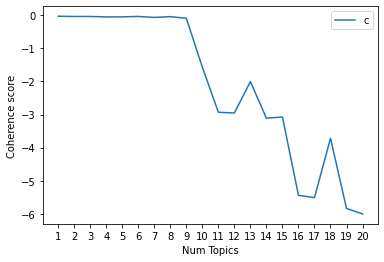

In [21]:
# Evaluate LDA model performance using topic coherence and determine optimal number of topics
# See performance benchmarks here: https://stackoverflow.com/questions/54762690/what-is-the-meaning-of-coherence-score-0-4-is-it-good-or-bad
# See example here: https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# How to determine optimal K: https://stackoverflow.com/questions/62032372/coherence-score-u-mass-18-is-good-or-bad

num_topics = range(1,21)
coherence_vals = []

for i in num_topics:
  # Train LDA model and fit
  LDA = LatentDirichletAllocation(n_components=i, random_state=100)
  LDA.fit(doc_term_matrix)
  doc_topic_distribution = LDA.transform(doc_term_matrix)

  # Determine average coherence
  coherence_val = metric_coherence_gensim(
      'u_mass',
      top_n=20,
      topic_word_distrib=LDA.components_,
      vocab=np.array(list(reverse_vocab_index.values())),
      dtm=doc_term_matrix,
      return_mean=True,
      # texts=speeches
    )
  coherence_vals.append(coherence_val)
  print(f"for {i} topic(s), coherence value: {coherence_val}")

# Plot coherence values
limit=21; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_vals)
plt.xlabel("Num Topics")
plt.xticks(list(range(1,21)))
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [22]:
OPTIMAL_NUM_TOPICS = 5

# See words in optimal number of topics
LDA = LatentDirichletAllocation(n_components=OPTIMAL_NUM_TOPICS, random_state=100)
LDA.fit(doc_term_matrix)
doc_topic_distribution = LDA.transform(doc_term_matrix)

# Analyze words in each topic
for i, topic in enumerate(LDA.components_):
  print(f"TOPIC {i+1}\n")
  top_words = [idx for idx in reversed(np.argsort(topic))]
  for word_index in top_words[:10]:
    print('%.02f\t%d = %s'%(topic[word_index], word_index, reverse_vocab_index[word_index]))

TOPIC 1

155.25	5399 = new
139.16	3505 = great
122.97	8303 = tonight
108.42	4408 = job
107.13	7770 = states
100.04	9084 = work
99.02	6228 = president
97.35	8259 = time
95.74	1614 = congress
95.60	9094 = world
TOPIC 2

1400.81	6314 = program
1071.74	1614 = congress
912.29	121 = administration
839.97	1691 = continue
822.52	3022 = federal
780.05	5399 = new
755.48	4033 = increase
721.34	5367 = need
720.09	9084 = work
672.14	2668 = energy
TOPIC 3

397.96	9094 = world
304.55	8259 = time
295.56	4663 = let
264.26	1012 = budget
256.83	5399 = new
255.96	3256 = freedom
246.27	9084 = work
245.79	3716 = help
243.78	5870 = peace
238.90	3320 = future
TOPIC 4

273.16	9094 = world
245.58	1614 = congress
231.10	5399 = new
223.51	8184 = terrorist
217.88	3716 = help
211.85	9084 = work
207.69	4313 = iraq
204.77	7266 = security
181.52	1286 = child
179.10	3256 = freedom
TOPIC 5

1342.76	9084 = work
1057.76	5399 = new
914.46	4408 = job
750.92	1286 = child
732.08	3716 = help
726.00	4529 = know
674.09	8259 = ti

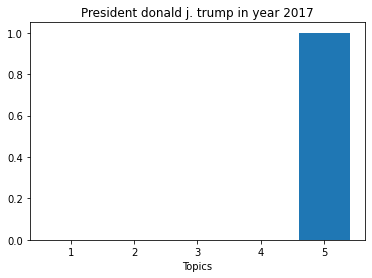

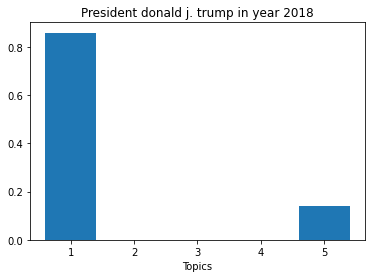

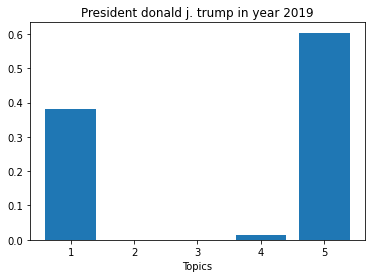

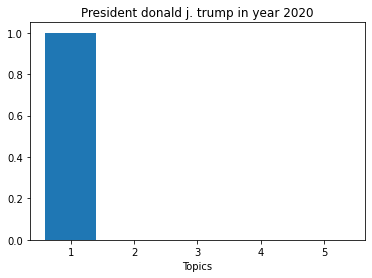

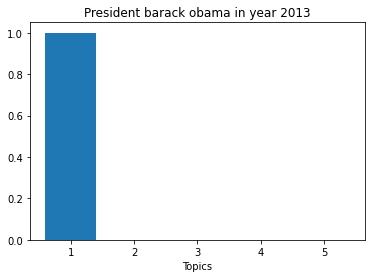

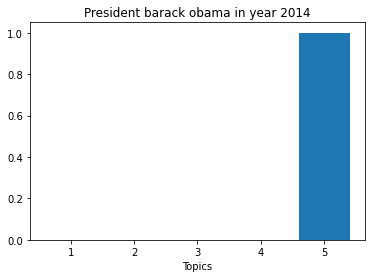

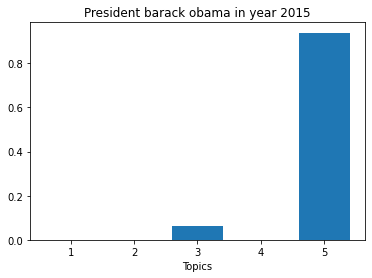

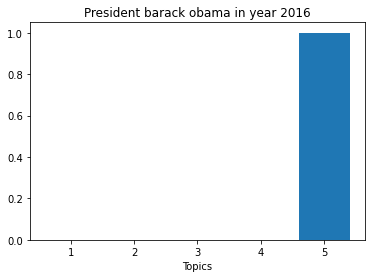

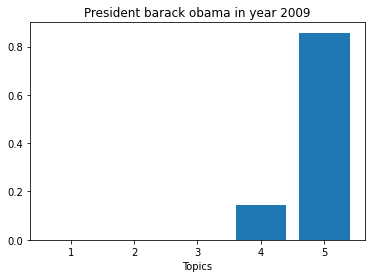

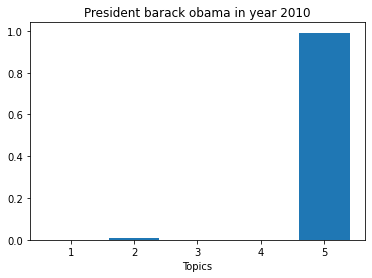

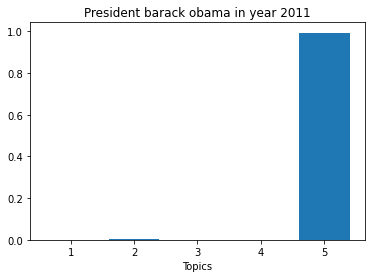

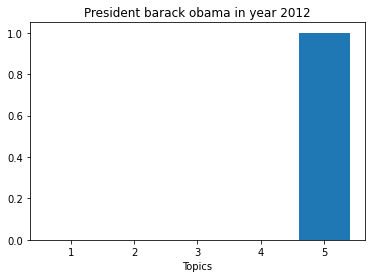

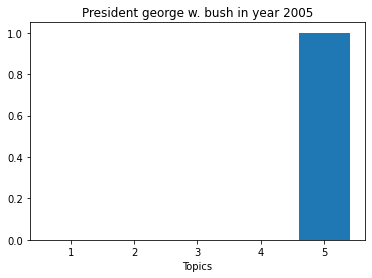

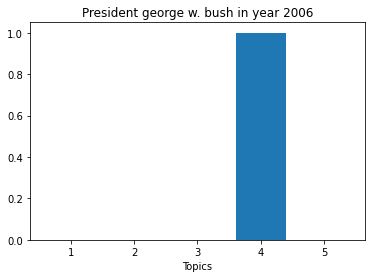

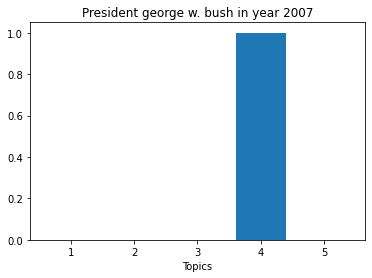

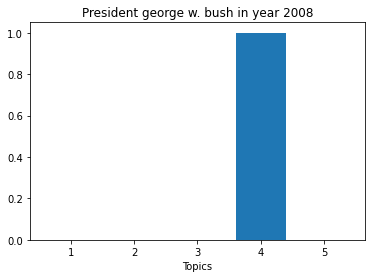

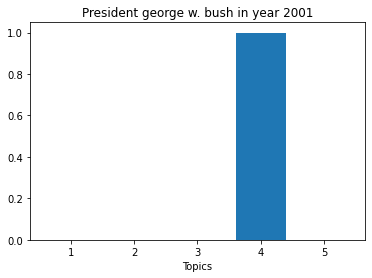

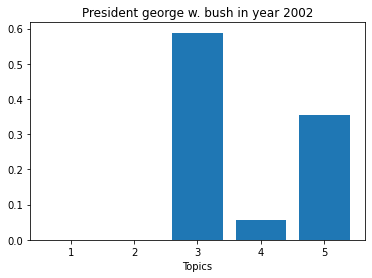

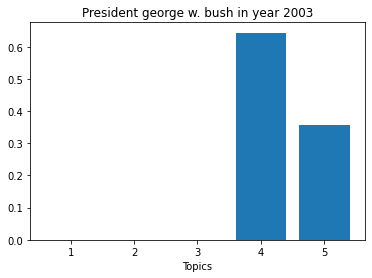

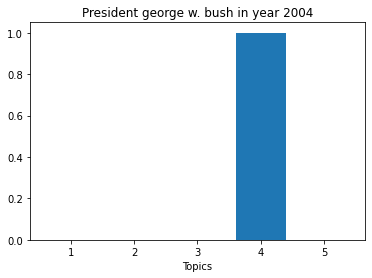

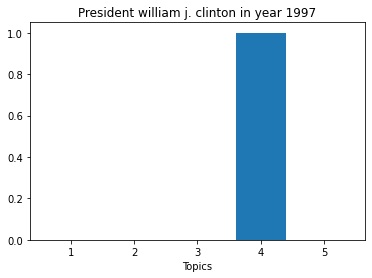

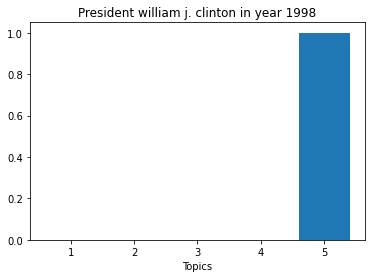

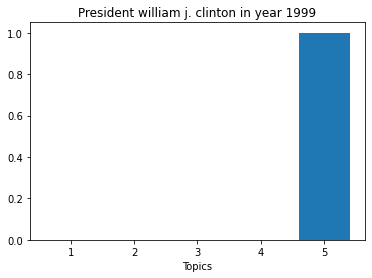

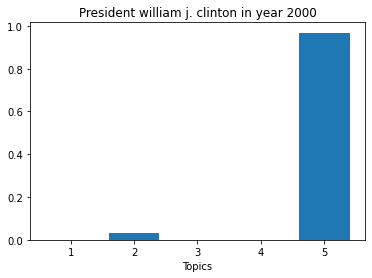

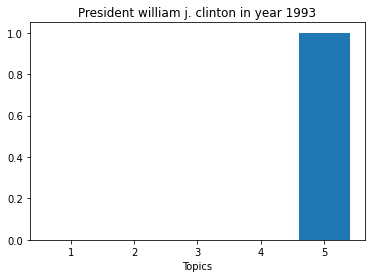

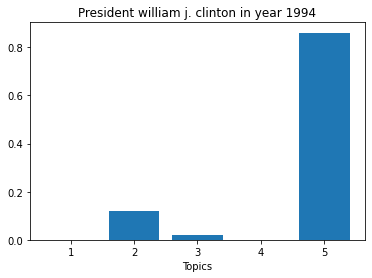

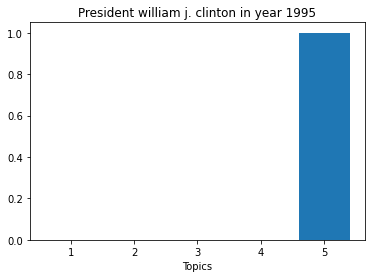

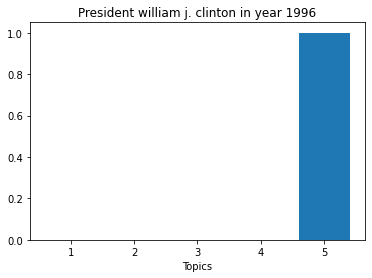

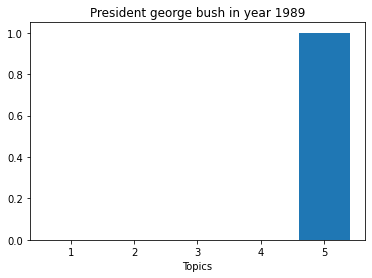

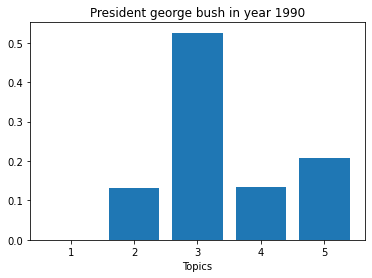

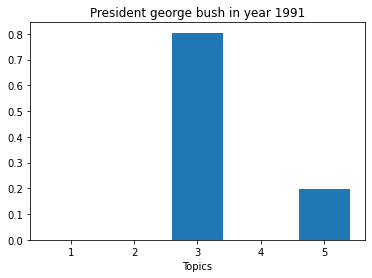

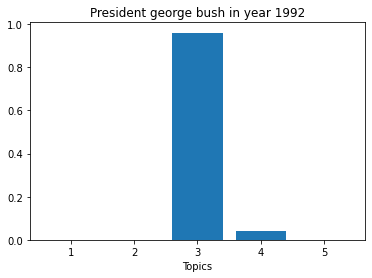

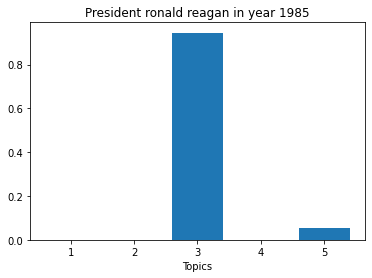

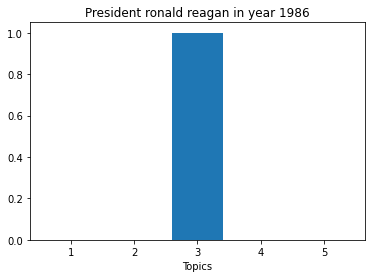

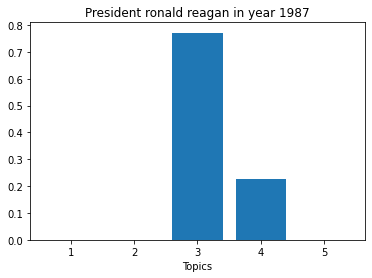

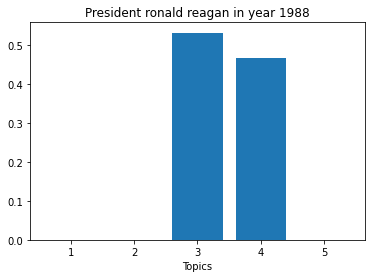

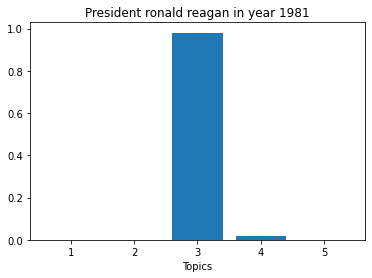

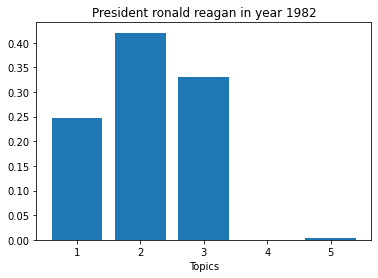

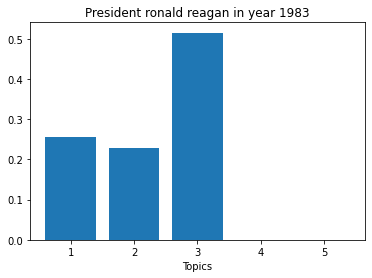

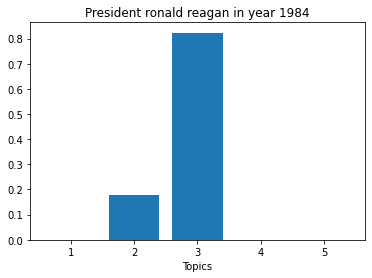

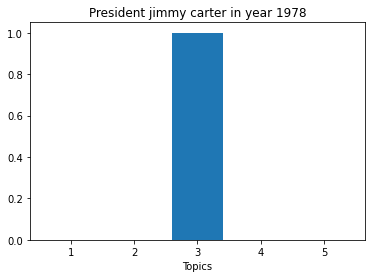

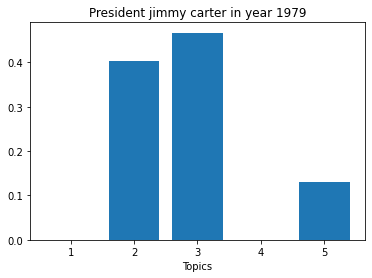

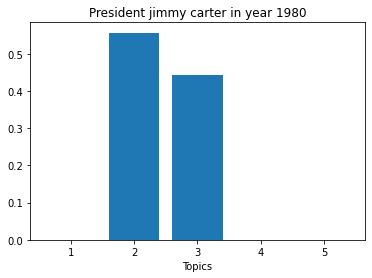

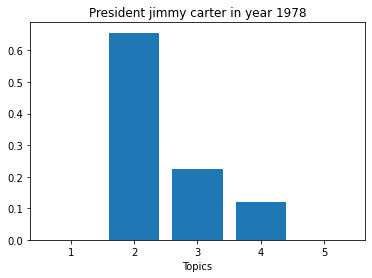

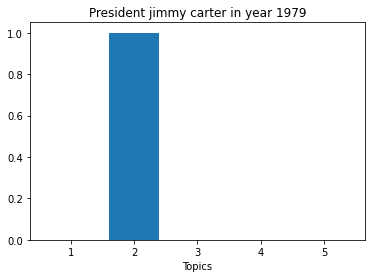

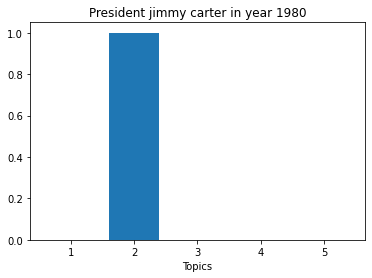

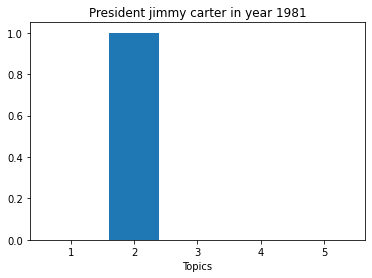

In [23]:
# Plot each document (speech) in terms of distribution of topics
for i in range(0,speeches_df_filtered.shape[0]):
  plt.bar(np.arange(len(doc_topic_distribution[i]) + 1)[1:],
        doc_topic_distribution[i])
  plt.xlabel("Topics")
  plt.xticks(np.arange(len(doc_topic_distribution[i]) + 1)[1:])
  plt.title(f"President {speeches_df_filtered.iloc[i]['president']} in year {speeches_df_filtered.iloc[i]['year']}")
  plt.show()

### Partisanship
[Does the average proportion of health-related words differ between Republicans and Democrats?]  

In [24]:
# Calculate proportions for each party for each president
republican_props_dict, democrat_props_dict = defaultdict(list), defaultdict(list)
for index, row in merged_df.iterrows():
  freq = 0
  for w in row['speech']:
    if w in health_dic:
      freq += 1
  
  prop = freq/len(row['speech'])
  democrat_props_dict[row['president']].append(prop) if row['is_democrat']=='True' else republican_props_dict[row['president']].append(prop)

# Average proportions for each president
republican_props, democrat_props = [], []
for president,props in republican_props_dict.items():
  avg_props = sum(props) / len(props)
  republican_props.append(avg_props)

for president,props in democrat_props_dict.items():
  avg_props = sum(props) / len(props)
  democrat_props.append(avg_props)

print(republican_props)
print(democrat_props)

[0.011334361711694097, 0.016110140864106292, 0.005111425656158702, 0.003513270017861437]
[0.0091838846747625, 0.014426526554342664, 0.006716053228341816]


With sample sizes of 4 and 3 for republicans and democrats (respectively), there will be low statistical power and the normality assumption cannot be fulfilled. Moreover, speeches given by a certain president are not independent. Instead, we will run Friedman's test (see assumptions below). See [this document](https://www.statstutor.ac.uk/resources/uploaded/repeated-measures.pdf) for additional reference.  
  
  
This means that the question now shifts to the following...  
**[Is there a difference in the distributions of the proportion of health-reated words (for republicans and democrats) between a president's 1st, 2nd, 3rd, and 4th SOTUA?]**

In [25]:
"""
ASSUMPTIONS:
1. Data is continuous
2. Data comes from a single group* (measured on at least 3 different occasions)
3. Group is random sample from population**
4. Observations are ranked within blocks with no ties

*In this case, the group is the SOTUA order (1st year, 2nd year, 3rd year, 4th year)
**Due to a lack of data, the group is representative of the population (there are only 4 speeches in each group) 

It should also be noted that a president serving two terms are treated as two distinct groups.
"""

# Recreate props dict for republicans and democrats but with strict group (speech) size of 4
"""
NOTE:
- data from Jimmy Carter's speeches are only available for his 2nd, 3rd, 4th, and end of 4th addresses -- we treat this as 1st, 2nd. 3rd 4th
- Jimmy Carter also has speech data from 1978 - 1980 but we skip these as this would form a group with 4 blocks
"""
seen_carter_years = []

# Sort merged_df to guarantee that we can separate a president's 1st and 2nd terms
sorted_merged_df = merged_df.sort_values(by='year')

republican_props_dict, democrat_props_dict = defaultdict(list), defaultdict(list)
for index, row in sorted_merged_df.iterrows():
  if row['president'] == 'jimmy carter':
    if row['year'] in seen_carter_years:
      # Duplicate Carter speech
      continue
    else:
      seen_carter_years.append(row['year'])


  freq = 0
  for w in row['speech']:
    if w in health_dic:
      freq += 1
  prop = freq/len(row['speech'])

  if len(democrat_props_dict[row['president']]) == 4 and row['is_democrat'] == 'True':
    # President is democrat and first term is already filled (with 4 speeches)
    democrat_props_dict[row['president']+'_2'].append(prop)
  elif len(republican_props_dict[row['president']]) == 4 and row['is_democrat']=='False':
    # President is republican and first term is already filled (with 4 speeches)
    republican_props_dict[row['president']+'_2'].append(prop)
  else:
    democrat_props_dict[row['president']].append(prop) if row['is_democrat']=='True' else republican_props_dict[row['president']].append(prop)

# Filter out empty lists in both dicts
clean_republican_props_dict, clean_democrat_props_dict = {}, {}
for k,v in republican_props_dict.items():
  if len(v) != 0:
    clean_republican_props_dict[k] = v
for k,v in democrat_props_dict.items():
  if len(v) != 0:
    clean_democrat_props_dict[k] = v

# print(clean_republican_props_dict)
# print(clean_democrat_props_dict)

# Run Friedman's test on Republicans and Democrats
alpha = 0.05
rep_stat, rep_p = friedmanchisquare(*clean_republican_props_dict.values())
dem_stat, dem_p = friedmanchisquare(*clean_democrat_props_dict.values())

print(rep_p)
print(dem_p)

if rep_p < alpha:
  print("We reject the null that there is no difference between the population distributions of the year a Republican president gave a SOTUA.")
else:
  print("We fail to reject the null that there is no difference between the population distributions of the year a Republican president gave a SOTUA.")

if dem_p < alpha:
  print("We reject the null that there is no difference between the population distributions of the year a Democrat president gave a SOTUA.")
else:
  print("We fail to reject the null that there is no difference between the population distributions of the year a Democrat president gave a SOTUA.")

0.005388573978507904
0.30844104118400123
We reject the null that there is no difference between the population distributions of the year a Republican president gave a SOTUA.
We fail to reject the null that there is no difference between the population distributions of the year a Democrat president gave a SOTUA.


### Frequency of keywords
[Is there a relationship between frequency of health-related words and percentage spend on the health department?]


Loading the health related words dictionary 

Finds the frequency of health_dic words per year

In [35]:
def create_data_df(raw_set):
  frequencies = []
  for speech in raw_set["speech"]:
    search_speech = ' '.join(speech)
    freq = 0
    i = 0
    while i < len(search_speech):
      for word in health_dic:
        segment = search_speech[i: i + len(word)]
        if segment == word:
          freq += 1
          i += len(word) - 1
          continue
      i += 1
    frequencies.append(freq / len(speech))
  data = raw_set.copy()
  data['freq'] = frequencies
  
  # Fixes datatype issues
  data['freq'] = pd.to_numeric(data['freq'])
  data['year'] = pd.to_numeric(data['year'])
  data['% spent'] = pd.to_numeric(data['percent health budget spend'])
  data['is_dem'] = data["is_democrat"].apply(lambda x: x == "True")

  data.drop(['url', 'speech', 'percent health budget spend', "is_democrat"], 
            axis=1, inplace=True)
  return data

test_data = create_data_df(test_set)
train_data = create_data_df(train_set)
all_data = test_data.append(train_data)
all_data

,president,year,freq,% spent,is_dem
11,barack obama,2012,0.006777,0.244524,True
2,donald j. trump,2019,0.012041,0.273024,False
29,george bush,1990,0.006881,0.143584,False
17,george w. bush,2002,0.009727,0.228820,False
42,jimmy carter,1978,0.014473,0.102843,True
39,ronald reagan,1983,0.003683,0.105166,False
21,william j. clinton,1998,0.011025,0.212337,True
10,barack obama,2011,0.009775,0.253338,True
44,jimmy carter,1979,0.015425,0.106877,True
37,jimmy carter,1981,0.010912,0.109129,True


####Exploratory Graphs

In [36]:
#donkey image

donkey = parse_path("""M1275.96,12643.92c-25-28-21-69,17-147
	c19-40,41-106,49-155c20-107,81-231,177-358c38-51,73-98,77-105c3-6-49,28-118,75c-181,124-410,268-519,326c-84,44-110,53-219,71
	c-253,43-519,16-613-60c-15-13-15-19,3-89c42-165,157-357,303-508c125-129,234-199,362-232c32-8,57-26,103-75c82-88,88-100,57-120
	c-13-9-96-47-183-84c-88-38-184-82-214-97l-54-28l73-12c69-12,102-26,102-44c0-19-63-66-183-136c-192-112-291-180-337-230
	c-42-46-52-71-22-59c34,14,169,18,176,6c5-7-19-40-61-84c-38-40-85-100-105-133c-101-166-126-383-78-674c11-65,77-373,86-399
	c5-16,29,27,58,104c63,167,216,414,325,526c63,64,152,129,177,129c8,0,11-119,9-472c-2-500-7-571-55-746c-60-218-186-398-361-514
	c-94-62-199-198-252-324c-104-247-64-528,128-909c186-368,269-471,449-561c84-41,105-48,174-52l79-4l59,73c71,87,93,96,202,80
	c103-16,145-14,208,9c99,34,152,84,262,247c120,177,143,208,230,297c150,154,319,238,560,279c62,11,91,22,118,43
	c77,62,160,115,213,135c277,105,495-92,598-541c14-63,17-133,18-425c1-282,4-371,19-459c63-389,186-755,408-1216
	c107-220,116-262,125-540l5-185l-87-210c-47-115-124-288-171-384l-84-174l25-81c53-175,59-218,59-446c0-195-2-226-27-340
	c-30-143-90-334-145-465l-38-90l-100-1c-163-2-272-50-394-173c-168-170-206-372-99-527c88-129,383-244,738-289l54-7l-59-31
	c-169-90-284-283-284-480c0-234,157-430,395-492c31-8,95-17,143-20c48-4,155-15,237-26c617-80,995,19,1144,300l33,63l-21,72
	c-39,133-74,320-72,383c2,78-11,162-45,280c-25,88-25,95-10,118c21,33,60,33,108,0c20-14,42-25,48-25c21,0,50,83,50,146
	c0,110-54,239-175,414c-125,181-206,374-205,489c1,91,28,204,68,281c21,41,68,131,103,200c74,143,89,196,89,319c0,111-21,193-99,389
	c-83,207-101,277-101,387c0,71,6,105,26,160c14,39,32,95,39,125c55,222,178,322,396,321c129,0,250-26,542-117c133-41,289-83,347-94
	c294-54,661-85,885-75c552,24,1030,128,1715,374c47,17,98,31,114,31h29l-7-223c-12-363-52-640-113-773c-52-114-53-214-8-574
	c26-211,14-345-41-459c-30-59-121-155-177-185c-30-17-45-40-106-165c-39-80-88-193-110-251l-40-105l-75-7c-138-13-234-52-323-132
	c-172-155-205-409-75-574c49-62,133-113,255-155c326-112,372-122,577-121c110,1,162,6,217,21l71,19l-27-40c-128-187-94-454,78-627
	c111-111,219-154,428-169c70-5,180-17,243-26c77-11,185-17,325-17c183-1,223,2,315,22c236,51,386,153,470,320l22,44l-20,71
	c-12,39-28,109-37,156s-23,108-31,137c-14,51-14,52,16,99c37,60,75,174,95,288c8,49,18,92,21,95s31,6,63,6h56l3,39
	c4,48-23,126-91,261c-199,398-192,617,25,835c170,170,307,553,308,856c0,198-62,459-151,636c-28,55-29,64-29,190
	c0,339,88,598,389,1147c216,394,241,450,295,669c27,105,52,192,56,192c12,0,20-55,20-130c0-37,8-105,17-151c22-109,21-298-2-489
	c-10-80-18-210-18-290c-1-125,2-154,22-209l22-63l-20-44c-12-24-30-76-40-116c-20-73-24-97-61-368c-23-167-49-271-89-352l-29-56
	l24-234c62-616,137-928,268-1112c25-36,55-68,66-71c28-9,122,20,205,63c87,46,187,144,243,238c103,174,158,389,198,764
	c21,200,25,988,5,1090c-17,90-39,154-63,185c-17,21-19,36-15,78c9,85-12,258-58,497c-24,124-49,268-55,320s-16,127-22,165
	c-5,39-14,334-18,660c-7,533-10,601-28,701c-26,136-73,286-119,379c-76,152-263,396-433,566c-371,369-790,580-1255,629
	c-282,29-332,32-525,27c-331-9-537-41-1245-192c-521-111-705-136-1220-166c-610-35-1250,102-1829,393c-61,30-113,61-117,69
	s-14,39-23,69c-20,72-92,179-211,315c-53,60-94,116-93,124c2,8,24,20,51,27c52,13,77,29,77,49c0,21-132,140-360,324
	c-118,95-263,216-322,269c-125,110-131,125-67,171l40,30l-38,28c-22,15-126,75-232,133s-221,129-256,158c-86,71-155,164-155,208
	c0,37,14,49,77,62l38,8l-74,48c-40,27-137,78-215,114c-262,120-353,185-434,307c-43,65-41,89,9,136l42,39l-46,19
	c-111,48-497,164-764,231c-35,9-51,23-103,88c-228,286-656,686-791,740c-116,46-332,87-559,107
	C1301.96,12662.92,1290.96,12660.92,1275.96,12643.92z M10113.96,3549.92c21-24,52-72,69-108c29-60,31-73,31-170
	c-1-131-19-200-131-491c-99-256-131-362-146-485c-19-148,11-287,85-400l34-51l-29-79c-63-175-198-418-346-626l-77-108l-35,8
	c-45,9-104,9-158-1l-42-7l34,44c19,25,40,62,47,83c19,54,17,168-4,230c-18,51-18,52,3,92c11,23,23,62,27,88c4,31,21,71,50,116
	c64,98,120,230,211,502c84,252,121,343,176,434c33,55,34,59,39,201c7,151,27,334,53,480c30,169,57,290,65,290
	C10073.96,3591.92,10093.96,3572.92,10113.96,3549.92z""")
donkey.vertices -= donkey.vertices.mean(axis=0)

#elephant image

elephant = parse_path("""M740.71,757.56c26.49-0.12,57.72-12.66,87.41-36.98
	c19.75-16.17,30.72-20.11,58.04-20.83c70.3-1.85,151.69-61.66,189.92-139.57c26.4-53.8,31.32-72.77,50.93-196.43
	c18.75-118.22,31.08-163.71,48.69-179.54c17.09-15.37,31.25-6.67,61.78,37.98c30.3,44.3,48.13,56.43,83.9,57.09
	c47.54,0.87,75.15-28.29,65.12-68.79c-3.43-13.84-8.02-16.06-37.07-17.86l-33.15-2.06l-21.64-41.21
	c-31.49-59.97-46.32-78.71-70.32-88.82c-70.31-29.64-147.22,10.62-190.01,99.47c-20.89,43.39-37.24,58.51-63.23,58.5
	c-6.04,0-22.62,7.11-36.84,15.81c-37.66,23.03-80.47,18.58-80.75-8.38c-0.06-6.08,19.67-49.53,43.85-96.56l43.97-85.49l0.42-78.84
	c0.34-64.07,2.66-82.98,12.37-100.91c11.52-21.28,11.53-22.38,0.31-30.64c-15.41-11.34-122.55-11.77-144.65-0.57
	c-15.93,8.07-16.12,9.12-14.05,76.13c1.82,58.83,0.3,71.45-11.32,94.04c-18.4,35.77-29.04,38.13-41.93,9.27
	c-5.81-13-32.58-51.08-59.48-84.63c-47.07-58.68-48.78-62-45.15-87.81c2.32-16.5,0.9-29.72-3.69-34.33
	c-13.74-13.83-76.16-8.95-114.58,8.96c-32.4,15.11-40.18,16.18-88.42,12.24c-47.84-3.91-54.15-3.07-66.14,8.84
	c-14.86,14.77-15.4,18.81-7.21,54.63c5.1,22.34,2.07,35.28-25.62,109.34c-17.27,46.2-34.37,84.98-37.98,86.17
	c-10.84,3.57-32.16-24.23-42.92-55.97c-18.39-54.23-19.17-97.47-2.7-149.99c16.53-52.7,17.67-69.5,5.28-77.42
	c-11.82-7.55-113.36-7.11-141.53,0.62c-44.1,12.1-48.2,33.67-25.05,131.95c10.7,45.45,12.7,68.02,9.21,104
	c-3.81,39.32-2.01,53.89,12.47,100.87c9.31,30.2,15.95,62.95,14.75,72.78c-2.11,17.3-2.85,16.83-23.05-14.7
	c-11.48-17.92-25.17-34.24-30.41-36.27c-6.7-2.6-8.4-9.24-5.73-22.38c2.3-11.29-0.22-26.52-6.34-38.46
	C47.5,80.03,11.21,50.01,4.63,56.55c-2.12,2.11-4.18,16.7-4.57,32.42c-0.55,21.92,2.92,32.48,14.87,45.28
	c8.57,9.18,19.19,16.71,23.59,16.72c10.85,0.04,45.44,44.91,58.12,75.41c8.1,19.47,9.42,37.24,6.18,82.83
	C96.1,403.57,117.8,472.01,178,546.4c36.15,44.68,110.46,95.66,169.02,115.98c49.02,17,112.17,19.44,257.98,9.96l78.54-5.11
	l-3.43,25.1c-2.64,19.33-0.27,29.14,10.31,42.65C702.35,750.23,720.1,757.66,740.71,757.56L740.71,757.56z M753.45,726.76
	c-10.6,0.01-20.23-3.38-29.8-10.13c-14.09-9.94-14.86-13.63-11.05-53.06c3.73-38.63,2.61-44.54-12.7-66.79
	c-19.78-28.75-27.57-64.83-20.11-93.15c6.72-25.49,42.71-57.39,74.63-66.14c13.41-3.68,30.35-6.69,37.63-6.68
	c16.67,0.01,80.18,31.52,80.15,39.77c-0.01,3.38-12.59-1.27-27.95-10.34c-48.23-28.48-106.94-19.58-141.71,21.46
	c-23.19,27.38-22.62,54.02,2.17,101.33c17.87,34.09,19.39,41.5,15.51,75.38c-5.15,44.86,1.48,55.95,33.5,56.05
	c28.35,0.09,59.91-18.9,79.94-48.09c13.83-20.17,25.1-28.67,25.07-18.91c-0.03,10.25-42.53,53.99-64.21,66.08
	C778.71,722.36,765.46,726.75,753.45,726.76L753.45,726.76z M485.55,76.97c-11.08-0.08-18.43-0.47-18.42-1.3
	c0.01-1.8,7.6-28.06,16.88-58.37c9.28-30.31,19.09-57.42,21.81-60.25c2.71-2.83,22.91,21.46,44.87,53.97
	c21.97,32.52,39,59.95,37.86,60.97C585.65,74.55,518.79,77.2,485.55,76.97L485.55,76.97z""")
elephant.vertices -= elephant.vertices.mean(axis=0)



In [38]:
# General Plotting function

# chages color of scatter points based on president 

COLORS = {
      "donald j. trump": (0.95, 0.9, 0.25),
      "barack obama": (0.4, 0.8, 0.5),
      "george w. bush": (0.9, 0.6, 0),
      "william j. clinton": (0.35, 0.7, 0.9),
      "george bush": (0.8, 0.4, 0),
      "ronald reagan": (0.8, 0.6, 0.7),
      "jimmy carter": (0, 0.45, 0.7)
  }

def get_colors(row):
  return COLORS[row['president']]

def get_graphable(x_var, y_var):
  graph_data = pd.DataFrame()
  graph_data[x_var.title()] = all_data[x_var]
  graph_data[y_var.title()] = all_data[y_var]
  graph_data["Political Party"] = all_data["is_dem"].replace(
      {True: "Democrat", False: "Republican"})
  graph_data["President"] = all_data["president"].map(lambda s: s.title())

  graph_colors = {k.title(): v for k, v in COLORS.items()}
  return (graph_data, graph_colors)

# changes marker symbol based on partisanship
def get_marker(row):
  return "*" if row["is_dem"] else "p"

marker_dict = {"Democrat": donkey, "Republican": elephant}

def scale_axis(data_label):
  SCALING = 1.08
  range = (max(all_data[data_label]) - min(all_data[data_label]))*SCALING
  avg = (max(all_data[data_label]) + min(all_data[data_label])) / 2
  return (avg - range/2, avg + range/2)
  
def plot_items(x_var, y_var, ax):
  ax.set(ylim=scale_axis(y_var), xlim=scale_axis(x_var))

  graph_data = get_graphable(x_var, y_var)[0]
  graph_colors = get_graphable(x_var, y_var)[1]

  sns.scatterplot(data=graph_data, x=x_var.title(), y=y_var.title(), 
                  hue='President', palette=graph_colors, ax=ax,
                  style='Political Party', s=200, alpha=0.7, markers = marker_dict, edgecolor = "black", linewidth = 0.6)

AttributeError: ignored

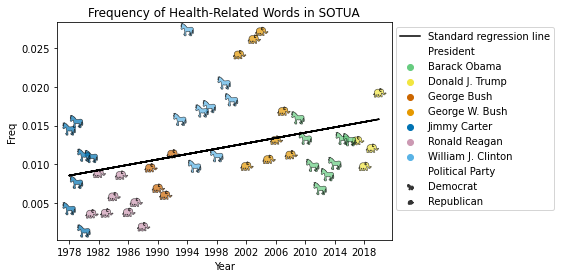

In [39]:
# Change in healthcare mentions over time
fig, ax = plt.subplots()

plot_items('year', 'freq', ax)
ax.set_xlabel("Year")
ax.set_title("Frequency of Health-Related Words in SOTUA")
ax.set_xticks(range(min(all_data["year"]), max(all_data["year"]) + 1, 4))

# brief linear regression to show general pattern
m, b = np.polyfit(all_data["year"], all_data["freq"], 1)
ax.plot(all_data["year"], m*all_data["year"]+b, color='black',
        label='Standard regression line')
legend = ax.legend(bbox_to_anchor=(1.5, 1))
for handle in legend.Handles:
  handle._sizes = [30]

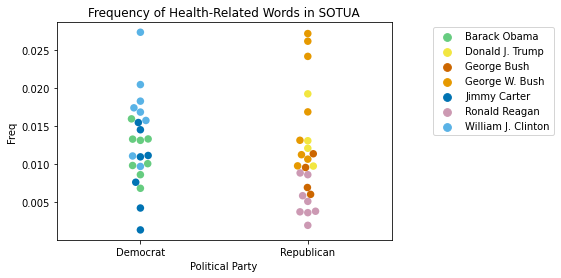

In [40]:
# Healthcare mentions compared by partisanship

def partisan_swarm(y_var, ax):
  graph_data = get_graphable('is_dem', y_var)[0]
  graph_colors = get_graphable('is_dem', y_var)[1]

  sns.swarmplot(x='Political Party', y=y_var.title(), data=graph_data, 
                hue='President', palette=graph_colors, s=7.5,
                ax=ax)

fig, ax = plt.subplots()

partisan_swarm('freq', ax)
ax.set_title("Frequency of Health-Related Words in SOTUA")
ax.legend(bbox_to_anchor=(1.5, 1))

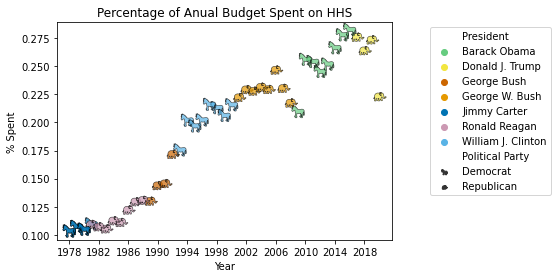

In [41]:
# graph frequencies of healthcare terms vs year
fig, ax = plt.subplots()
plot_items('year', '% spent', ax)
ax.set_xlabel("Year")
ax.set_title("Percentage of Anual Budget Spent on HHS")
ax.set_xticks(range(min(all_data["year"]), max(all_data["year"]) + 1, 4))

# brief linear regression to show general pattern
m, b = np.polyfit(all_data["year"], all_data["% spent"], 1)
# ax.plot(all_data["year"], m*all_data["year"]+b, color='black',
#         label='Standard regression line')
ax.legend(bbox_to_anchor=(1.1, 1))

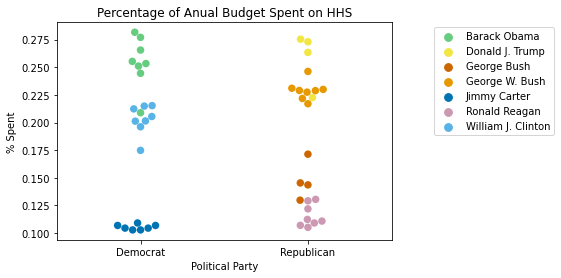

In [42]:
# compares partisanship and healthcare spending
fig, ax = plt.subplots()

partisan_swarm('% spent', ax)
ax.set_title("Percentage of Anual Budget Spent on HHS")
ax.legend(bbox_to_anchor=(1.5, 1))

#### Standard regression


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f48a9b09fd0>)

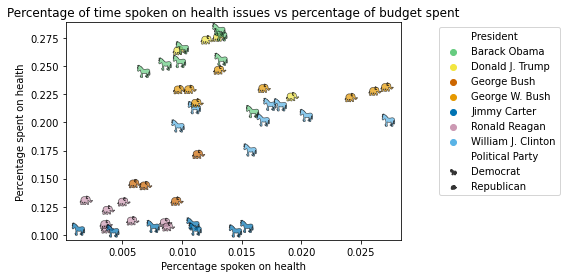

In [43]:
# Plots all the data points on a healthcare word frequency vs spending plot
def scatter_plot():
  fig, ax = plt.subplots()

  # plots percent spent and percent spoken on health

  plot_items("freq", "% spent", ax)

  ax.set_title("Percentage of time spoken on health issues vs percentage of budget spent")
  ax.set_ylabel("Percentage spent on health")
  ax.set_xlabel("Percentage spoken on health")

  ax.legend(bbox_to_anchor=(1.1, 1))

  return fig, ax

scatter_plot()

                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     15.57
Date:                Wed, 11 Aug 2021   Prob (F-statistic):           0.000365
Time:                        15:51:24   Log-Likelihood:                 58.914
No. Observations:                  37   AIC:                            -113.8
Df Residuals:                      35   BIC:                            -110.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1289      0.017      7.414      0.0

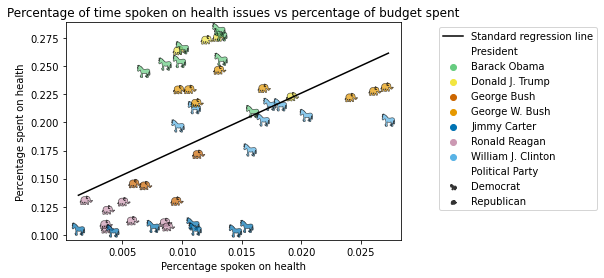

In [44]:
# linear regression

def run_regression(train_data, test_data):
  X = sm.add_constant(train_data['freq'])
  y = train_data['% spent']

  model = sm.OLS(y, X).fit()

  print(model.summary())
  print(f" - MSE Training:{eval_measures.mse(y, model.predict(X))}")

  def get_x():
    if len(test_data['freq']) > 1:
      return sm.add_constant(test_data['freq'])
    else:
      test_data['const'] = [1]
      return test_data[['const', 'freq']]
  if len(test_data) != 0:
    mse_test = eval_measures.mse(test_data['% spent'], 
                               model.predict(get_x()))
  
    print(f" - MSE Testing: {mse_test}")
  return model

fig, ax = scatter_plot()

def plot_line(model, name=None, color='black', ax=ax):
  x_space = np.linspace(all_data['freq'].min(),all_data['freq'].max(),300)
  ax.plot(x_space, model.predict(sm.add_constant(x_space)),
        color=color, label=name)
  
model = run_regression(train_data, test_data)
plot_line(model, 'Standard regression line')
ax.legend(bbox_to_anchor=(1.1, 1))

Noticibly, the data divides into clusters before and after clinton. Thus, we decided to run regression by cluster to avoid simpsons paradox. We give the following justification
1. Clinton's Health Security Act healthcare reform push in 1993 most likely introduced tons of healthcare vocabulary into mainstream discourse, whereas there was never that large of an emphasis on healthcare before him. Many words from our dictionary were most likely unwittingly influenced by Clinton.
2. There was a sizable spike in the 90s in healthcare spending
3. Health care prices accelerated in the 90s, becoming double the rate of inflation.

#### Pre - post Clinton cluster Split regression

In [45]:
# Splits

POST_CLINTON_PREZ = ["donald j. trump", "barack obama", "george w. bush", "william j. clinton"]

pre_clinton_test = test_data[~test_data['president'].isin(POST_CLINTON_PREZ)]
post_clinton_test = test_data[test_data['president'].isin(POST_CLINTON_PREZ)]

pre_clinton_train = train_data[~train_data['president'].isin(POST_CLINTON_PREZ)]
post_clinton_train = train_data[train_data['president'].isin(POST_CLINTON_PREZ)]

print(pre_clinton_test.shape)
print(pre_clinton_train.shape)
print(post_clinton_test.shape)
print(post_clinton_train.shape)

(5, 5)
(14, 5)
(5, 5)
(23, 5)


=== PRE CLINTON ===
                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9455
Date:                Wed, 11 Aug 2021   Prob (F-statistic):              0.350
Time:                        15:51:30   Log-Likelihood:                 36.300
No. Observations:                  14   AIC:                            -68.60
Df Residuals:                      12   BIC:                            -67.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1101      0.012

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


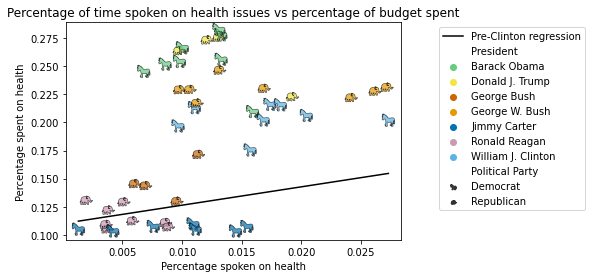

In [46]:
print("=== PRE CLINTON ===")
model = run_regression(pre_clinton_train, pre_clinton_test)

fig, ax = scatter_plot()
plot_line(model, 'Pre-Clinton regression', ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1))

=== POST CLINTON ===
                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     3.836
Date:                Wed, 11 Aug 2021   Prob (F-statistic):             0.0636
Time:                        15:51:31   Log-Likelihood:                 51.372
No. Observations:                  23   AIC:                            -98.74
Df Residuals:                      21   BIC:                            -96.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2629      0.01

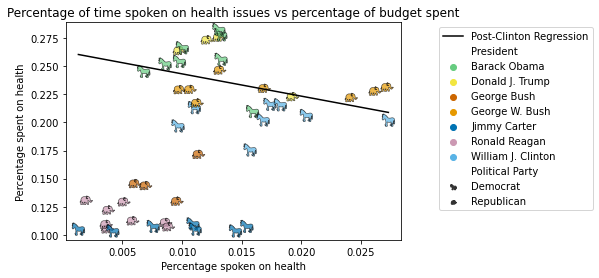

In [47]:
print("=== POST CLINTON ===")
model = run_regression(post_clinton_train, post_clinton_test)

fig, ax = scatter_plot()
plot_line(model, 'Post-Clinton Regression', ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1))

#### Split by each president

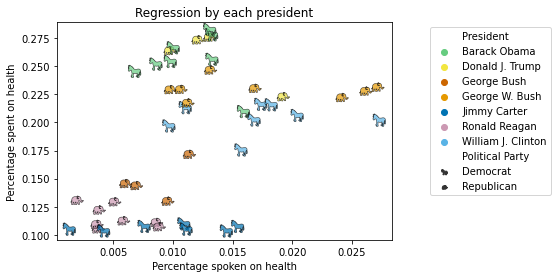

In [48]:
all_fig, all_ax = scatter_plot()
all_ax.set_title("Regression by each president")

prez_coeff = {"president" : [], "coeff": []}

def presidential_regression(name):
  # datasets too small to get a train and test set
  train_prez = pd.concat([train_data[train_data['president'] == name],
                         test_data[test_data['president'] == name]])

  model = run_regression(train_prez, [])

  plot_line(model, name=None, color=COLORS[name], ax=all_ax)
  prez_coeff["president"].append(name)
  prez_coeff["coeff"].append(model.params[1])
  
  fig_prez, ax_prez = scatter_plot()
  plot_line(model, name=None, color=COLORS[name], ax=ax_prez)
  ax_prez.set_title(f"Regression - {name}")
  fig_prez.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                 -0.127
Method:                 Least Squares   F-statistic:                    0.3240
Date:                Wed, 11 Aug 2021   Prob (F-statistic):              0.594
Time:                        15:51:38   Log-Likelihood:                 33.208
No. Observations:                   7   AIC:                            -62.42
Df Residuals:                       5   BIC:                            -62.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1043      0.002     51.120      0.0

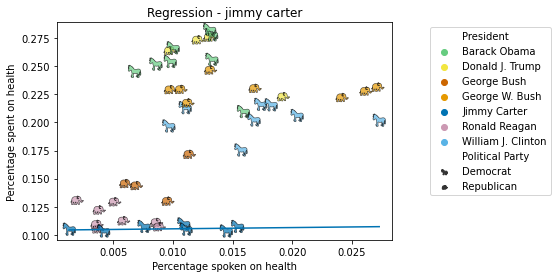

In [49]:
#Jimmy Carter Regression
presidential_regression("jimmy carter")

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     1.765
Date:                Wed, 11 Aug 2021   Prob (F-statistic):              0.232
Time:                        15:51:41   Log-Likelihood:                 27.038
No. Observations:                   8   AIC:                            -50.08
Df Residuals:                       6   BIC:                            -49.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1257      0.008     15.276      0.0

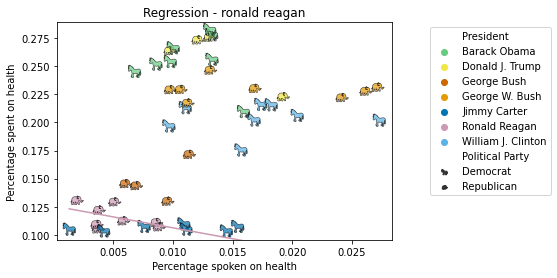

In [50]:
presidential_regression("ronald reagan")

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                 -0.156
Method:                 Least Squares   F-statistic:                    0.5961
Date:                Wed, 11 Aug 2021   Prob (F-statistic):              0.521
Time:                        15:51:41   Log-Likelihood:                 11.636
No. Observations:                   4   AIC:                            -19.27
Df Residuals:                       2   BIC:                            -20.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1188      0.038      3.103      0.0

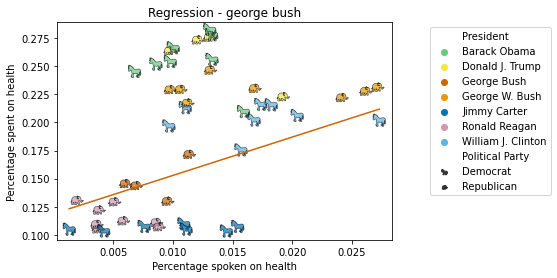

In [51]:
presidential_regression("george bush")

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.159
Method:                 Least Squares   F-statistic:                   0.03894
Date:                Wed, 11 Aug 2021   Prob (F-statistic):              0.850
Time:                        15:51:44   Log-Likelihood:                 23.787
No. Observations:                   8   AIC:                            -43.57
Df Residuals:                       6   BIC:                            -43.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1994      0.018     11.370      0.0

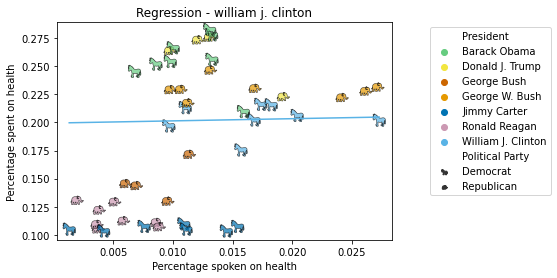

In [52]:
presidential_regression("william j. clinton")

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.156
Method:                 Least Squares   F-statistic:                   0.05368
Date:                Wed, 11 Aug 2021   Prob (F-statistic):              0.824
Time:                        15:51:47   Log-Likelihood:                 27.404
No. Observations:                   8   AIC:                            -50.81
Df Residuals:                       6   BIC:                            -50.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2308      0.009     26.449      0.0

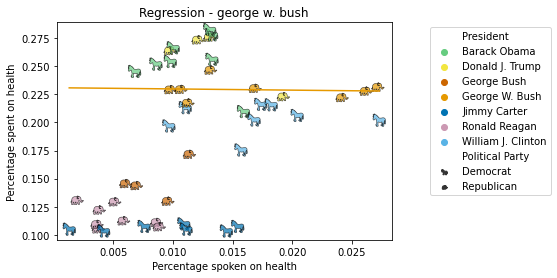

In [53]:
presidential_regression("george w. bush")

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.138
Method:                 Least Squares   F-statistic:                    0.1497
Date:                Wed, 11 Aug 2021   Prob (F-statistic):              0.712
Time:                        15:51:49   Log-Likelihood:                 19.616
No. Observations:                   8   AIC:                            -35.23
Df Residuals:                       6   BIC:                            -35.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2679      0.035      7.622      0.0

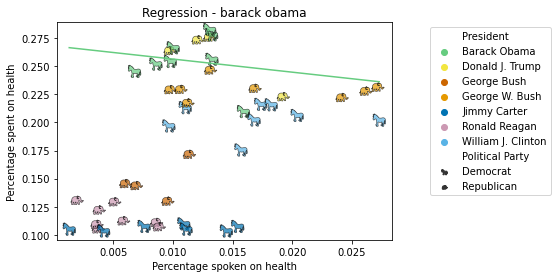

In [54]:
presidential_regression("barack obama")

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     5.006
Date:                Wed, 11 Aug 2021   Prob (F-statistic):              0.155
Time:                        15:51:50   Log-Likelihood:                 12.228
No. Observations:                   4   AIC:                            -20.46
Df Residuals:                       2   BIC:                            -21.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3278      0.032     10.253      0.0

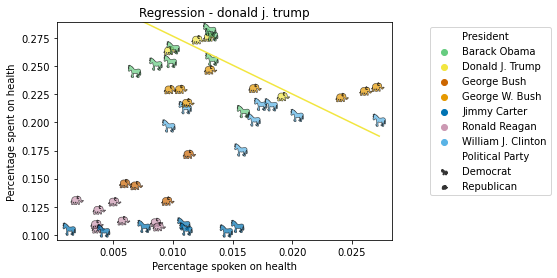

In [55]:
presidential_regression("donald j. trump")

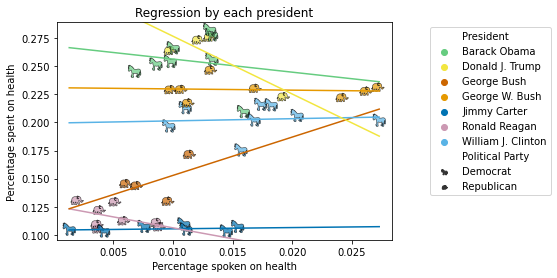

In [56]:
all_fig



Text(0, 0.5, 'Coefficient')

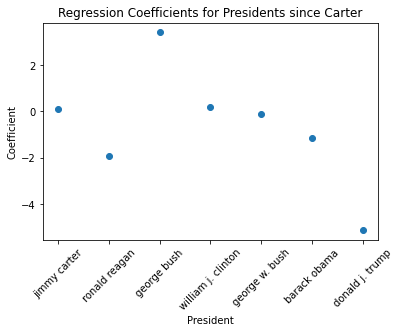

In [57]:
plt.plot(prez_coeff["president"], prez_coeff["coeff"], "o")
plt.xticks(rotation=45)
plt.title("Regression Coefficients for Presidents since Carter")
plt.xlabel("President")
plt.ylabel("Coefficient")